In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTEN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# reading the youth model dataset 
youth_model = pd.read_csv("datasets/youth_model.csv")

youth_model.head()

,hmlsmorethan1Yr,dv_neglect,dv_physical,dv_physical_rel,dv_sexual_rel,subsabuse,drugabuse,SPA
0,1,1,1,1,0,0,0,4
1,1,0,0,0,1,0,0,4
2,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,4


In [6]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [7]:
scores = []

# Normal SVC

In [8]:
# creating our X and y

features = ['dv_neglect', 'dv_physical', 'dv_physical_rel', 'dv_sexual_rel', 'subsabuse', 'drugabuse', 'SPA']

X = youth_model[features]
y = youth_model['hmlsmorethan1Yr']

In [9]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
# Instantiate support vector machine.
svc = SVC(random_state=42)

svc.fit(X_train, y_train)

SVC(random_state=42)

In [11]:
# train score
svc.score(X_train, y_train)

0.6569626394953906

In [12]:
# test score
svc.score(X_test, y_test)

0.6569767441860465

The model shows sign that it is able to able to generalize new data based on the train and test scores.

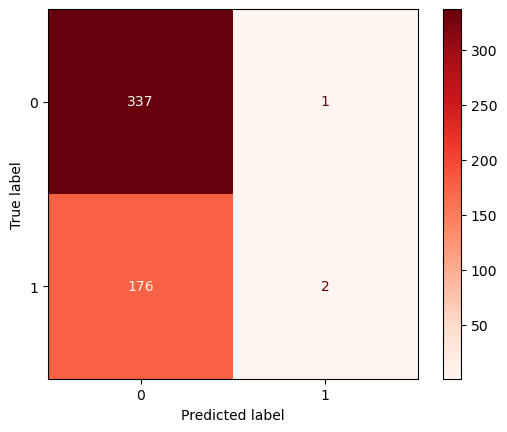

In [13]:
# Normal Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap = 'Reds');

In [14]:
preds1 = svc.predict(X_test)

balanced_accuracy: 0.5041386875872614
recall: 0.011235955056179775
precision: 0.6666666666666666
f1 score: 0.022099447513812154


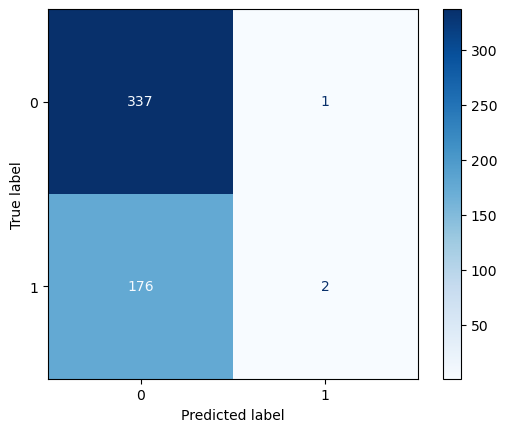

In [15]:
scores.append(evaluation(X_test, y_test, preds1, svc))

# Confusion Matrix of SVC Model
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 337 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 1 time that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 176 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 2 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 1% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 66% were actually true positives.
* For the F1 score, the model's performance indicates a significant bias towards correctly identifying negative cases (youth who did not stay homeless more than 1 year).

## Oversampling with Hypertuned SVC Model

In [16]:
pipe = make_pipeline(RandomOverSampler(random_state=42),
                    SVC(random_state=42))

In [17]:
param_grid = {
    'randomoversampler__sampling_strategy': [.25, .5, .75, 1.0],
    'svc__C': [0.1, 1, 10],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Kernel type
    'svc__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

In [18]:
gs = GridSearchCV(pipe,
                 param_grid=param_grid,
                 n_jobs=-1,
                 cv=5)

In [19]:
gs.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0],
                         'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']})

In [20]:
# Train Score 
gs.score(X_train, y_train)

0.6555070354196991

In [21]:
# Test Score 
gs.score(X_test, y_test)

0.6550387596899225

Overall, the model seems to be doing well in generalizing new data. 

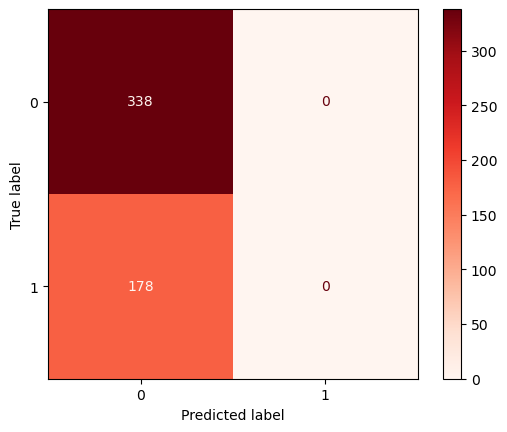

In [22]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap = 'Reds');

# Confusion Matrix of SVC with RandomOverSampler
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 338 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 0 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 178 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 0 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.


# Balanced Accuracy for Oversampling

In [23]:
gs2 = GridSearchCV(pipe,
                 param_grid=param_grid,
                 n_jobs=-1, 
                 cv=5, 
                 scoring='balanced_accuracy')

In [24]:
gs2.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0],
                         'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='balanced_accuracy')

In [25]:
# train score
gs2.score(X_train, y_train)

0.5894105566038719

In [26]:
# test score
gs2.score(X_test, y_test)

0.5829732065687122

The model shows that overall, it is performing well in generalizing new data. The only issue is that there is still room to improve the test score

balanced_accuracy: 0.5829732065687122
recall: 0.550561797752809
precision: 0.4298245614035088
f1 score: 0.4827586206896552


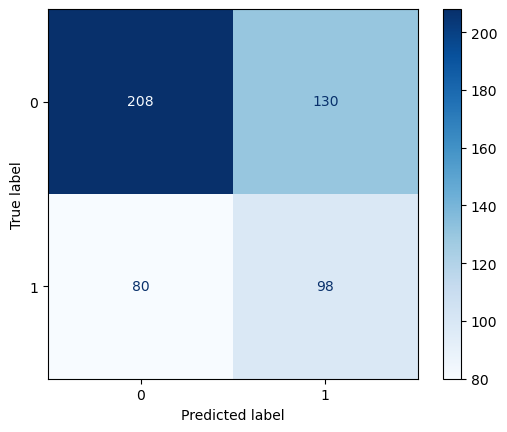

In [27]:
# making prediction
preds2 = gs2.predict(X_test)

# evaluating the model

scores.append(evaluation(X_test, y_test, preds2, gs2))

# Confusion Matrix of SVC with RandomOverSampler, GridSearch, and Balanced Accuracy
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 208 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 130 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 80 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 98 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 55% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 43% were actually true positives.
* For the F1 score, the model's performance indicates a moderate bias towards correctly identifying negative cases (youth who did not stay homeless more than 1 year).

In [28]:
pd.DataFrame(scores, index=['svc', 'RandomOverSampler'])

,balanced_accuracy,recall,precision,f1_score
svc,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.582973,0.550562,0.429825,0.482759


# SMOTEN Method for Hypertuned SVC Model

In [29]:
pipe3 = make_pipeline(SMOTEN(random_state=42), SVC(random_state=42))

In [30]:
param_grid3 = {
    'smoten__k_neighbors' : [3, 5, 7],
    'svc__C': [0.1, 1, 10],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Kernel type
    'svc__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

In [31]:
gs3 = GridSearchCV(pipe3,
                 param_grid=param_grid3,
                 n_jobs=-1, 
                 cv=5, 
                 scoring='balanced_accuracy')

In [32]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'smoten__k_neighbors': [3, 5, 7],
                         'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='balanced_accuracy')

In [33]:
# train score
gs3.score(X_train, y_train)

0.6163196797364499

In [34]:
# test score
gs3.score(X_test, y_test)

0.5723356159829799

The model seems to show sign of overfit because the train score is higher than the test score.

balanced_accuracy: 0.5723356159829799
recall: 0.5056179775280899
precision: 0.42452830188679247
f1 score: 0.46153846153846156


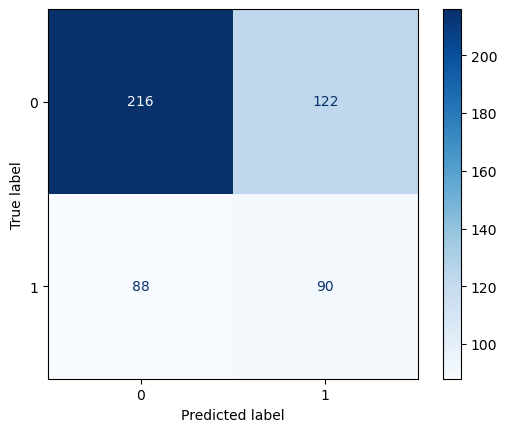

In [35]:
# create prediction
preds3 = gs3.predict(X_test)

# find out respective scores
scores.append(evaluation(X_test, y_test, preds3, gs3))

# Confusion Matrix of SVC with SMOTEN
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 216 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 122 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 88 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 90 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 51% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 42% were actually true positives.
* For the F1 score, the model's performance indicates a moderate bias towards correctly identifying negative cases (youth who did not stay homeless more than 1 year).

In [36]:
pd.DataFrame(scores, index=['svc', 'RamdomOverSampler', 'SMOTEN'])

,balanced_accuracy,recall,precision,f1_score
svc,0.504139,0.011236,0.666667,0.022099
RamdomOverSampler,0.582973,0.550562,0.429825,0.482759
SMOTEN,0.572336,0.505618,0.424528,0.461538


## ADASYN with Hypertuned SVC

In [37]:
pipe4 = make_pipeline(ADASYN(random_state=42),
                    SVC(random_state=42))

In [38]:
param_grid4 = {
    'adasyn__n_neighbors':[3,5,7],
    'svc__C': [0.1, 1, 10],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Kernel type
    'svc__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

In [39]:
gs4 = GridSearchCV(pipe4,
                 param_grid=param_grid4,
                 n_jobs=-1, 
                 cv=5, 
                 scoring='balanced_accuracy')

In [40]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'adasyn__n_neighbors': [3, 5, 7],
                         'svc__C': [0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='balanced_accuracy')

In [41]:
# train score
gs4.score(X_train, y_train)

0.5835656425600233

In [42]:
# test score
gs4.score(X_test, y_test)

0.562861511867562

The model seems to show sign of overfit because the train score is slightly higher than the test score.

balanced_accuracy: 0.562861511867562
recall: 0.5280898876404494
precision: 0.40869565217391307
f1 score: 0.46078431372549017


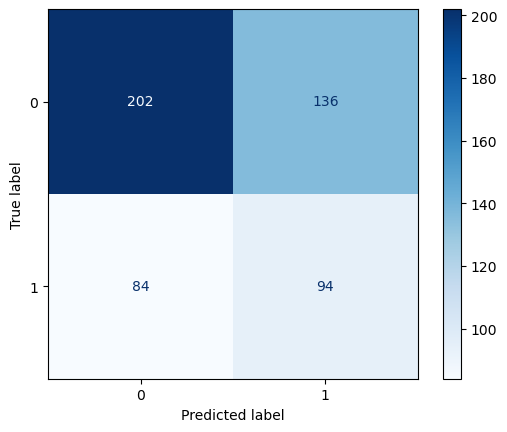

In [43]:
preds4 = gs4.predict(X_test)

scores.append(evaluation(X_test, y_test, preds4, gs4))

# Confusion Matrix of SVC with ADASYN
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 202 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 136 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 84 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 94 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 53% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 41% were actually true positives.
* For the F1 score, the model's performance indicates a moderate bias towards correctly identifying negative cases (youth who did not stay homeless more than 1 year).

In [44]:
pd.DataFrame(scores, index = ['svc', 'RandomOverSampler',
                             'SMOTEN', 'ADASYN'])

,balanced_accuracy,recall,precision,f1_score
svc,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.582973,0.550562,0.429825,0.482759
SMOTEN,0.572336,0.505618,0.424528,0.461538
ADASYN,0.562862,0.528090,0.408696,0.460784


## Overweighing minority class importance in algorithms

In [45]:
svc5 = SVC(random_state=42, class_weight='balanced')

svc5.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [46]:
# train score
svc5.score(X_train, y_train)

0.5487627365356623

In [47]:
# test score
svc5.score(X_test, y_test)

0.5426356589147286

The model's performance seems to generalize the test data well based on the train and test scores. 

balanced_accuracy: 0.5405225716375242
recall: 0.5337078651685393
precision: 0.38306451612903225
f1 score: 0.4460093896713615


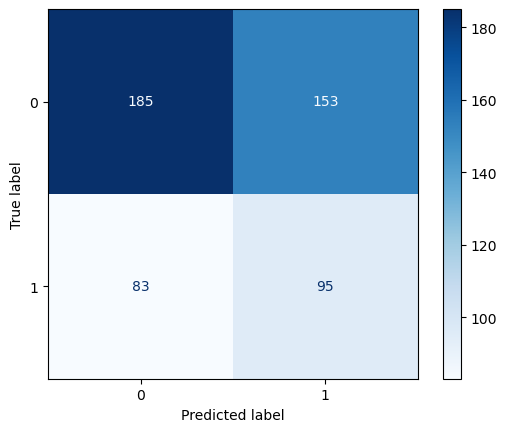

In [48]:
scores.append(evaluation(X_test, y_test, svc5.predict(X_test), svc5))

# Confusion Matrix of SVC with Overweighing
_____

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 185 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 153 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 83 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 95 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 53% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 38% were actually true positives.
* For the F1 score, the model's performance indicates a bias towards correctly identifying negative cases (youth who did not stay homeless more than 1 year).



In [49]:
pd.DataFrame(scores, index=['svc', 'RandomOverSampler', 'SMOTEN', 'ADASYN', 'Weightedsvc'])

,balanced_accuracy,recall,precision,f1_score
svc,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.582973,0.550562,0.429825,0.482759
SMOTEN,0.572336,0.505618,0.424528,0.461538
ADASYN,0.562862,0.528090,0.408696,0.460784
Weightedsvc,0.540523,0.533708,0.383065,0.446009
